# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Расшифровка колонок
customerID - идентификационный номер клиента
BeginDate - дата начала пользования услугами
EndDate - дата окончания пользования услугами
Type - тип оплаты: ежемесячный, годовой и тд
PaperlessBilling – безналичный расчет
PaymentMethod – способ оплаты
MonthlyCharges – ежемесячные траты на услуги
TotalCharges – всего потрачено денег на услуги
Dependents – наличие иждивенцев
Senior Citizen – наличие пенсионного статуса по возрасту
Partner – наличие супруга(и)
MultipleLines – наличие возможности ведения параллельных линий во время звонка

### План работы:

1. Подготовка данных к анализу:
- Открыть файл, сделать первичные выводы о результате их соединения;

- Проверить наличие дубликатов, пропусков, соответствие типов данных;

- Объединить файл, заполнить пропуски, выделить целевой признак. 

2. Исследовательский анализ:

- На основе анализа создать дополнительные признаки, возможно удалить признаки, с низкой корреляцией или просто не имеющих смысла для обучения модели;

- Проверить дисбаланс классов.

3. Подготовка данных к машинному обучению:

- Провести кодирование категориальных признаков, возможно провести масштабирование числовых признаков;

- Разбить выборку на обучающую и тестовую.

4. Обучить модели:

- Модели градиентного буста;

- Возможно имеет смысл попробовать случайный лес и логистическую регрессию.


## Предобработка данных 

Ниже импортируем все необходимые библиотеки и создадим переменные для датасетов:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
import warnings
pd.set_option('display.max_columns', None)

warnings.filterwarnings("ignore")


In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

Откроем каждый датасет, проверим на наличие пропусков и сделаем по ним вывод:

In [3]:
df_contract

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [5]:
df_contract.duplicated().value_counts()

False    6998
True       45
dtype: int64

In [6]:
df_internet

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...
6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
4801-JZAZL,DSL,Yes,No,No,No,No,No


In [7]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [8]:
df_internet.duplicated().value_counts()


True     5389
False     128
dtype: int64

In [9]:
df_personal

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
...,...,...,...,...
6840-RESVB,Male,0,Yes,Yes
2234-XADUH,Female,0,Yes,Yes
4801-JZAZL,Female,0,Yes,Yes


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [11]:
df_personal.duplicated().value_counts()

True     7027
False      16
dtype: int64

In [12]:
df_phone

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
...,...
2569-WGERO,No
6840-RESVB,Yes
2234-XADUH,Yes


In [13]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [14]:
df_phone.duplicated().value_counts()

True     6359
False       2
dtype: int64

Пропусков и дубликатов найдено не было, но так как в таблицах количество данных не совпадает они появятся при соединении. Столбец EndDate будет преобразован в бианрный целевой признак, который модели у будут пытаться предсказать. 

Далее соединим таблицы, но перед этим создадим признаки обозначающие пользуется ли клиент телефоном или интернетом или нет:


In [15]:
datasets = [df_contract, df_personal, df_internet, df_phone]

datasets[2]['internet'] = 'Yes'
datasets[3]['phone'] = 'Yes'

df = df_contract.join(datasets[1:]).reset_index()

Проверим появились ли дубли после соединения:

In [16]:
df.duplicated().sum()

0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Дубликатов нет, но есть пропуски, их заполним значениями No


In [18]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Данные подготовлены к анализу.

## Исследовательский анализ

Проверим есть ли в датасете клиенты, подключились и не успели сделать оплату на момент создания датасета:

In [19]:
df.loc[df['TotalCharges']==' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,internet,MultipleLines,phone
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Yes,No,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,No,No,No,No,No,No,No,No,Yes
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes


Всего 11 таких клиентов, они не будут что либо значить для обучения модели, поэтому удалим их.

In [20]:
df = df.loc[df['TotalCharges']!=' ']
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

Далее создадим бинарный целевой признак:

In [21]:
df.loc[df['EndDate'] != 'No', 'target'] = 1
df.loc[df['EndDate'] == 'No', 'target'] = 0  
df['target'] = df['target'].astype(int)

Проверим целевой признак на наличие дисбаланса:

<AxesSubplot:title={'center':'Распределение целевого признака'}, xlabel='Значение признака', ylabel='Количество записей с соответствующим значением'>

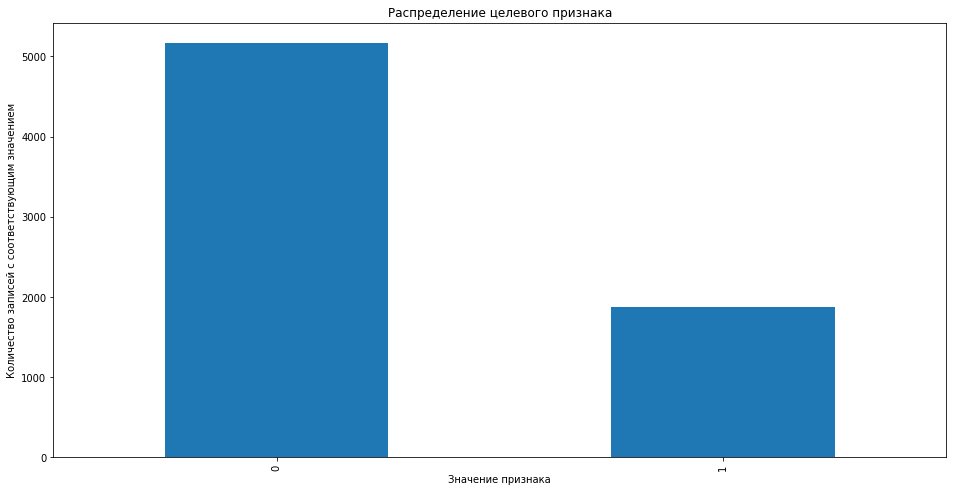

In [22]:
df_target = df['target']
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Значение признака')
ax.set_ylabel('Количество записей с соответствующим значением')
df_target.value_counts().plot(kind='bar', figsize=(16,8), ax=ax)

Виден дисбаланск классов, хорошим вариантом дальнейших действий будет upsampling. 

Далее проверим данные на наличие выбросов:


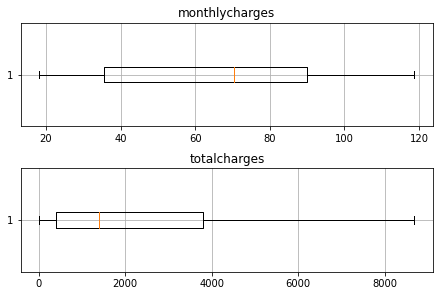

In [23]:
fig, ax = plt.subplots(2,1,constrained_layout=True)
ax[0].boxplot(df['MonthlyCharges'], vert=False)
ax[0].set_title('monthlycharges')
ax[0].grid(True)
ax[1].boxplot(df['TotalCharges'], vert=False)
ax[1].set_title('totalcharges')
ax[1].grid(True)
plt.show()

Судя по всему выбросов и аномалий нет. Далее проверим какая категория клиентов платила больше:

In [24]:

gone = df.loc[df['EndDate'] != 'No']
stayed = df.loc[df['EndDate'] == 'No']
gone['EndDate'] = pd.to_datetime(gone['EndDate'])
gone['together'] = round((gone['EndDate'] - gone['BeginDate'])/np.timedelta64(1, 'D'))

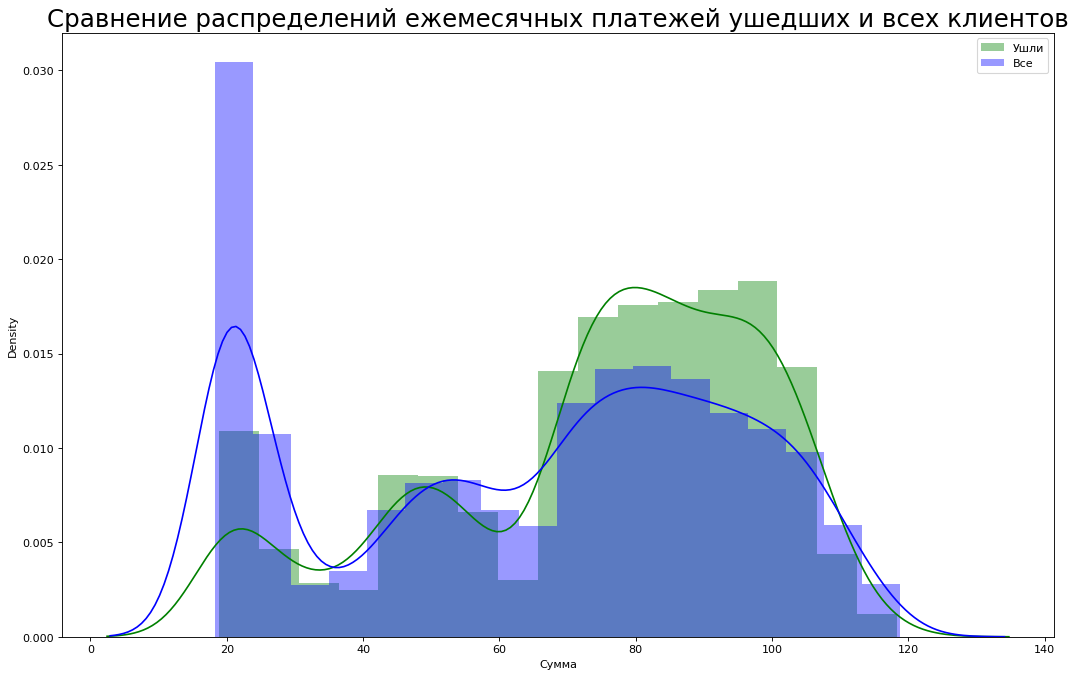

In [25]:
plt.figure(figsize=(16,10), dpi= 80)
sns.distplot(gone['MonthlyCharges'], color="g", label="Ушли")
sns.distplot(df['MonthlyCharges'], color="b", label="Все")

plt.title('Сравнение распределений ежемесячных платежей ушедших и всех клиентов', fontsize=22)
plt.legend()
plt.xlabel('Сумма')
plt.show()

Похоже ушедшие платили больше чем те кто остался, возможно это и стало причиной их ухода.

In [26]:
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [27]:
pd.pivot_table(df, values=['MonthlyCharges'], index=['PaymentMethod', 'target'],
                    aggfunc=sum)

MonthlyCharges
PaymentMethod             target                
Bank transfer (automatic) 0             83539.10
                          1             20091.90
Credit card (automatic)   0             83229.20
                          1             17946.60
Electronic check          0             96056.25
                          1             84288.75
Mailed check              0             53705.60
                          1             16803.60

Возможно уход клиентов как-то связан с оплатой электронным чеком, так как больше всего оплат было именно через них, но так же это может быть просто самым популярным способом оплаты. Причину по которой клиенты ушли найти не удалось, но возможно она связана с их переплатами и компании нужно задуматься о перебалансировке платежей за услуги. 

Далее все признаки которые возможно приведем к бинарным:

In [28]:
df['Male'] = pd.get_dummies(df['gender'], drop_first=True)
df = df.drop('gender',axis=1)
df['PaperlessBilling'] = df['PaperlessBilling'].map({'Yes':1,'No':0})

In [29]:
cols = ['Partner','Dependents', 'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies', 'internet', 'MultipleLines', 'phone']
for i in cols:
    df[i] = df[i].map({'Yes':1,'No':0})

In [30]:
def family(row):
    if ((row['Partner']==1)&(row['Dependents']==1)):
        return 1
    else:
        return 0

In [31]:
df['hasfamily'] = df.apply(family,axis=1)

Создадим признак в котором посчитаем количество сервисов:

In [32]:
df['NumofServices'] = df[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].sum(axis=1).astype('int')

Так же создадим признак в котром посчитаем сколько клиент обслуживался в компании:

In [33]:
def usagetime(row):
    if row['EndDate'] == 'No':
        return int(round(((pd.to_datetime('2020-02-01') - pd.to_datetime(row['BeginDate']))/np.timedelta64(1,'D')),0))
    else:
        return int(round(((pd.to_datetime(row['EndDate']) - pd.to_datetime(row['BeginDate']))/np.timedelta64(1,'D')),0))

In [34]:
df['Period'] = df.apply(usagetime, axis=1)

Создадим признак клиента, который подключился в последние 6 месяцев, таким образом для модели обозначим новых клиентов.

In [35]:
def newclnt(rows):
    if pd.to_datetime(rows['BeginDate'])>=pd.to_datetime('2019-08-01'):
        return 1
    else:
        return 0

In [36]:
df['New'] = df.apply(newclnt,axis=1)

Далее посмотрим корреляцию:

In [37]:
df_corr = df.corr()
df_corr['target'].sort_values()

Period             -0.354496
TotalCharges       -0.199484
OnlineSecurity     -0.171270
TechSupport        -0.164716
Dependents         -0.163128
hasfamily          -0.159245
Partner            -0.149982
NumofServices      -0.087882
OnlineBackup       -0.082307
DeviceProtection   -0.066193
Male               -0.008545
phone               0.011691
MultipleLines       0.040033
StreamingMovies     0.060860
StreamingTV         0.063254
SeniorCitizen       0.150541
PaperlessBilling    0.191454
MonthlyCharges      0.192858
internet            0.227578
New                 0.228056
target              1.000000
Name: target, dtype: float64

Судя по всему самая низкая корреляция с признаком пола клиента, в целом все признаки имею примерно одинаковую корреляцию и сильно выбивающихся значений нет, поэтому корреляция не может являться основанием для исключения признаков.


## Подготовка данных для обучения моделей.

Сначала уберем столбцы, которые нам не понадобятся и разделим датасет на target и features.

In [38]:
df = df.reset_index(drop=True)
features = df.drop(['customerID','BeginDate','EndDate','target'], axis=1)
target = df['target']

Далее поделим выборки на train и test:

In [39]:
features_train, features_test, target_train, target_test = train_test_split(
        features,target,stratify=target, test_size=0.2, random_state=12345)
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (5625, 23) (5625,)
Тестовая выборка:  (1407, 23) (1407,)


Разделилось корректно, теперь проведм кодирование категориальных признаков:

In [40]:
features_train_ohe=pd.get_dummies(features_train, drop_first=True)
features_test_ohe=pd.get_dummies(features_test, drop_first=True)

Далее скалируем числовые признаки:

In [41]:
numeric=['MonthlyCharges', 'TotalCharges', 'Period']
scaler=StandardScaler()
scaler.fit((features_train_ohe[numeric]))
features_train_ohe[numeric]=scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric]=scaler.transform(features_test_ohe[numeric])

Далее сделаем upsampling:

In [42]:
coef = target_train[target_train == 1].count() / target_train[target_train == 0].count()
coef

def upsample(features, target, coef):
    if (coef > 1):
        print('Положительных значений больше чем отрицательных, увеличение не требуется, ', coef)
        return features, target
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    repeat = round(1 / coef)
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, coef)
target_upsampled.value_counts()

1    4485
0    4130
Name: target, dtype: int64

В результате получили более близкое количество значений в каждом классе, подготовка данных завершена, можно приступать к обучению модели.

## Обучение моделей

### Логистическая регрессия

In [43]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model = LogisticRegression(solver='lbfgs', penalty='l2')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

{'C': 10}

In [77]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=10)
model.fit(features_upsampled, target_upsampled)
predict_true_probalities_lg = model.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predict_true_probalities_lg)

0.8522979639801006

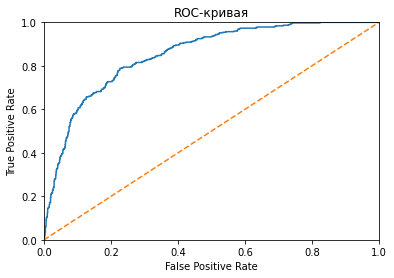

In [63]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
make_roc_curve(target_test, predict_true_probalities_lg)

Неплохой результат для логистической регрессии, но все равно еще далеко от желаемого результата более 0,88.

### Случайный лес

In [45]:
%%time

param_grid = {
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(2, 11, 2),
    'n_estimators': range(50, 101, 10)
}

model = RandomForestClassifier(random_state=12345)

grid_rfc = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_rfc.fit(features_upsampled, target_upsampled)
grid_rfc.best_params_

CPU times: user 23min 21s, sys: 7.53 s, total: 23min 29s
Wall time: 23min 30s


{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [76]:
model = RandomForestClassifier(random_state=12345, max_depth=30, min_samples_leaf=2, n_estimators=100, min_samples_split=2)
model.fit(features_upsampled, target_upsampled)
predict_true_probalities_rf = model.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predict_true_probalities_rf)

0.8737012802128684

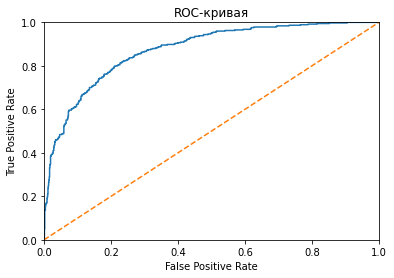

In [65]:
make_roc_curve(target_test, predict_true_probalities_rf)

Уже лучше, на данный момент лучший результат.

### Логистическая регрессия

In [47]:
%%time

param_grid = {
    "criterion":["gini", "entropy"],
    "max_depth": (2, 41, 2),
    "min_samples_split": range(2, 21, 2),
    "min_samples_leaf": range(2, 11, 2)
}

model = DecisionTreeClassifier(random_state=12345)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_upsampled, target_upsampled)
grid.best_params_

CPU times: user 31.2 s, sys: 192 ms, total: 31.4 s
Wall time: 31.5 s


{'criterion': 'entropy',
 'max_depth': 41,
 'min_samples_leaf': 4,
 'min_samples_split': 14}

In [67]:
model = DecisionTreeClassifier(random_state=12345, criterion='entropy', max_depth=41, min_samples_split=14, min_samples_leaf=2)
model.fit(features_upsampled, target_upsampled)
predict_true_probalities_dt = model.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predict_true_probalities_dt)

0.7937048004099994

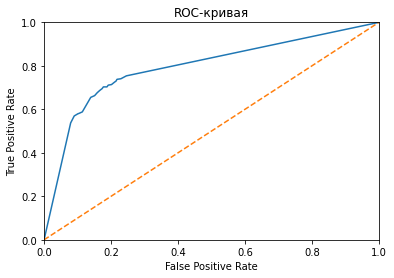

In [69]:
make_roc_curve(target_test, predict_true_probalities_dt)

Самый хучший результат у случайного дерево, но это не удивительно, модель проще чем случайный лес.

### CatBoost

In [54]:
%%time
CBC_model = CatBoostClassifier(random_state=12345, silent=True)

parameters = {'learning_rate': [0.03, 0.1], 'max_depth': [0, 10, 2], 'n_estimators': [0, 1000, 100]}

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(features_upsampled, target_upsampled)


CBC_model_gscv.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: user 3min 17s, sys: 2.45 s, total: 3min 20s
Wall time: 3min 53s


{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

In [74]:
%%time

model = CatBoostClassifier(max_depth=10, n_estimators=1000, eval_metric='AUC', random_seed=12345, verbose = 100)
model.fit(features_upsampled, target_upsampled)
predict_true_probalities_cb = model.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predict_true_probalities_cb)

Learning rate set to 0.02584
0:	total: 22.8ms	remaining: 22.8s
100:	total: 2.43s	remaining: 21.6s
200:	total: 4.84s	remaining: 19.2s
300:	total: 7.27s	remaining: 16.9s
400:	total: 9.65s	remaining: 14.4s
500:	total: 12.1s	remaining: 12.1s
600:	total: 14.6s	remaining: 9.7s
700:	total: 17.1s	remaining: 7.28s
800:	total: 19.5s	remaining: 4.84s
900:	total: 22s	remaining: 2.41s
999:	total: 24.4s	remaining: 0us
CPU times: user 24.4 s, sys: 240 ms, total: 24.7 s
Wall time: 26 s


0.9049520890816947

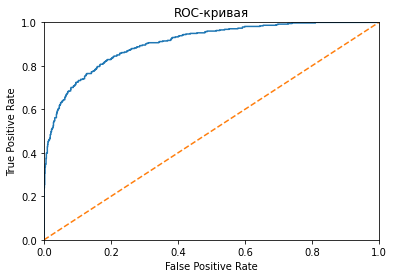

In [73]:
make_roc_curve(target_test, predict_true_probalities_cb)

Лучшая модель по показателю Roc-auc, площадь под auc кривой получилось равной 0.9049520890816947. 
 
## Вывод

Ниже приведем список с результатами моделей:

In [79]:
total_result = pd.DataFrame(columns = ['model', 'roc_auc'])

total_result.loc[1,'model'] = 'LogisticRegression'
total_result.loc[1,'roc_auc'] = roc_auc_score(target_test, predict_true_probalities_lg)

total_result.loc[2,'model'] = 'RandomForestClassifier'
total_result.loc[2,'roc_auc'] = roc_auc_score(target_test, predict_true_probalities_rf)

total_result.loc[3,'model'] = 'DecisionTreeClassifier'
total_result.loc[3,'roc_auc'] = roc_auc_score(target_test, predict_true_probalities_dt)

total_result.loc[4,'model'] = 'CatBoostClassifier'
total_result.loc[4,'roc_auc'] = roc_auc_score(target_test, predict_true_probalities_cb)

total_result

,model,roc_auc
1,LogisticRegression,0.852298
2,RandomForestClassifier,0.873701
3,DecisionTreeClassifier,0.793705
4,CatBoostClassifier,0.904952


Лучше моделью стала CatBoost, хотя что стало неожиданностью, так это то что случайный лес и логистическая регрессия показали хорошие результаты в целом почти достигнув желаемых 0,88. Далее приведем важность признаков для модели CatBoost:

In [80]:
features_train_importance = pd.DataFrame({'name' : features_upsampled.columns,
                                          'importance' : CBC_model_gscv.best_estimator_.feature_importances_})
features_train_importance = features_train_importance.sort_values('importance', ascending=False)
features_train_importance

,name,importance
18,Period,26.934731
1,MonthlyCharges,9.180638
2,TotalCharges,8.203041
15,Male,5.140999
0,PaperlessBilling,4.084570
23,PaymentMethod_Electronic check,3.730239
4,Partner,3.708527
19,New,3.520591
17,NumofServices,3.333960
13,MultipleLines,2.974005


Самым важным признаком ожидаемо стал период на протяжении которого клиент обслуживается в компании, ожидаемо, если клиент привык получать услуги в одном месте на протяжении долгого времени, то вряд ли он уйдет из компании и наоборот, новый клиент вероятнее уйдет из компании, если ему что-то не понравится или конкурент предоставит ему интересное предложение. Что более неожиданно модель оценила наличие телефона и интернета в списке услуг клиента в последней тройке, возможно доп услуги чаще влияют на присутствие клиента в компании. Так же советую компании обратить внимание на завышенные затраты клиентов которые ушли, так как судя по всему они платили больше чем те что остались, скорее всего нужно разработать индивидуальный тарифный план для них.
